<a href="https://colab.research.google.com/github/SianC7/LAIDS/blob/main/Final_PCA_1DCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CICIDS2017 Dataset

Extraction

In [1]:
import pandas as pd

# --- Data Collection ---

# Set pandas display options for wide output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


# Get Data file path
file_path = '/content/drive/MyDrive/Colab Notebooks/Honours Project/Datasets/cicids2017_cleaned.csv'
#file_path = '/content/drive/MyDrive/Colab Notebooks/Honours Project/Datasets/CICIDS2017 ADASYN Dataset/ADASYN_CICIDS2017_Dataset6.csv'
cicids2017_df = pd.read_csv(file_path, sep=",", comment="#", header=0)
cicids2017_df.columns = cicids2017_df.columns.str.strip()  # Strip whitespace from column names


print("\nInitial samples:")
print(f"cicids2017_df shape: {cicids2017_df.shape}")
# print(cicids2017_df.head().to_string())
#print(cicids2017_df.info())

# Print unique values and their counts for 'Attack Type'
print("\nAttack Type Distribution:")
print(cicids2017_df['Attack Type'].value_counts())

# --- Label Encoding ---

# Get unique attack types
attack_types = cicids2017_df['Attack Type'].unique()

# Create a mapping from attack type to integer label
attack_type_map = {'Normal Traffic': 0, 'Port Scanning': 1, 'Web Attacks': 2, 'Brute Force': 3, 'DDoS': 4, 'Bots': 5, 'DoS': 6} # Use the specified mapping


# Apply label encoding
cicids2017_df['Attack Type'] = cicids2017_df['Attack Type'].map(attack_type_map)

print("\nLabel Encoding Mapping:")
print(attack_type_map)


Initial samples:
cicids2017_df shape: (2520751, 53)

Attack Type Distribution:
Attack Type
Normal Traffic    2095057
DoS                193745
DDoS               128014
Port Scanning       90694
Brute Force          9150
Web Attacks          2143
Bots                 1948
Name: count, dtype: int64

Label Encoding Mapping:
{'Normal Traffic': 0, 'Port Scanning': 1, 'Web Attacks': 2, 'Brute Force': 3, 'DDoS': 4, 'Bots': 5, 'DoS': 6}


#Data Split

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# --- Train/val/test split ---
# Split label from datafram
X = cicids2017_df.drop('Attack Type', axis=1)
y = cicids2017_df['Attack Type']

# Split Data
X_temp, X_test, y_temp, y_test= train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify = y_temp)

# Shuffle the data
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = shuffle(X_val, y_val, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)


Visualisation of split

Input Shapes -> Train: (1613280, 52), Val: (403320, 52), Test: (504151, 52)
Labels distribution -> Train: [1340836   58044    1371    5856   81929    1247  123997], Val: [335209  14511    343   1464  20482    312  30999], Test: [419012  18139    429   1830  25603    389  38749]


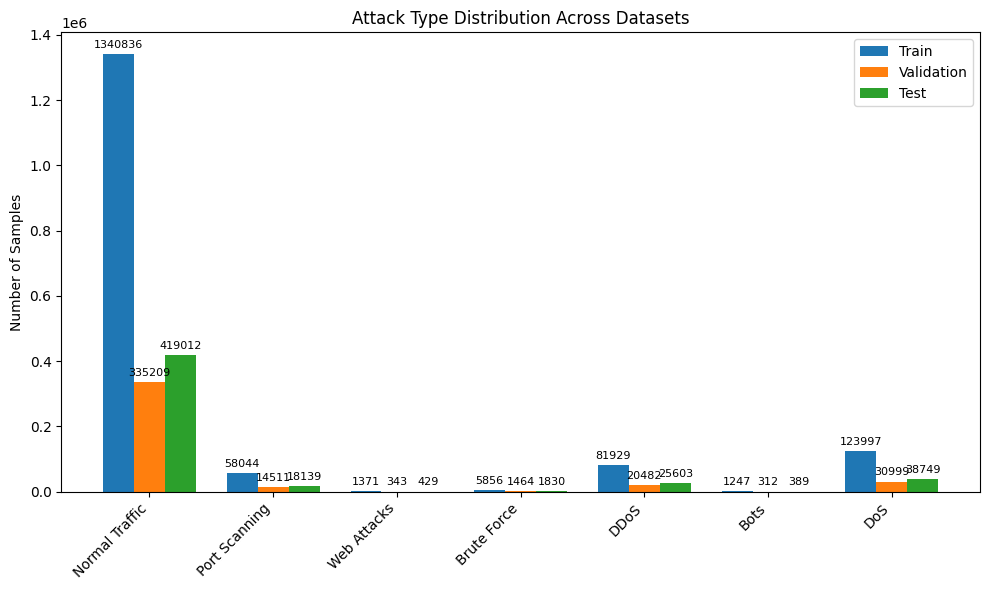

In [3]:
import numpy as np
import matplotlib.pyplot as plt

print(f"Input Shapes -> Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# Get the counts for each attack type in each dataset
train_counts = np.bincount(y_train)
val_counts = np.bincount(y_val)
test_counts = np.bincount(y_test)

# Get the number of unique attack types (based on the maximum index found)
num_attack_types = max(len(train_counts), len(val_counts), len(test_counts))

# Pad counts with zeros if some attack types are missing in a dataset split
train_counts = np.pad(train_counts, (0, num_attack_types - len(train_counts)), 'constant')
val_counts = np.pad(val_counts, (0, num_attack_types - len(val_counts)), 'constant')
test_counts = np.pad(test_counts, (0, num_attack_types - len(test_counts)), 'constant')


print(f"Labels distribution -> Train: {train_counts}, Val: {val_counts}, Test: {test_counts}")

# Data for plotting
datasets = ['Train', 'Validation', 'Test']
all_counts = np.array([train_counts, val_counts, test_counts])

# Get the original attack type names from the mapping
# Need to reverse the mapping to get names from labels
reverse_attack_type_map = {v: k for k, v in attack_type_map.items()}
labels = [reverse_attack_type_map.get(i, f'Unknown {i}') for i in range(num_attack_types)]

x = np.arange(len(labels))  # the label locations for attack types
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6)) # Increase figure size

rects1 = ax.bar(x - width, all_counts[0], width, label='Train')
rects2 = ax.bar(x, all_counts[1], width, label='Validation')
rects3 = ax.bar(x + width, all_counts[2], width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Samples')
ax.set_title('Attack Type Distribution Across Datasets')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right") # Rotate labels for better readability
ax.legend()

# Add value labels (optional, can make the plot cluttered with many categories)
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)


plt.tight_layout()
plt.show()

#Normalisation of data

In [4]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import numpy as np

# --- Normalize ---
#scaler = RobustScaler() # Initialize the scaler
#scaler = MinMaxScaler() # Initialize the scaler
scaler = StandardScaler() # Initialize the scaler

# Apply the scaler
X_train_scaled = scaler.fit_transform(X_train) # Standardise data features accoriding to th training data
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Print the shape of the scaled data to verify
print(f"Shape of X_train after scaling: {X_train_scaled.shape}")
print(f"Shape of X_val after scaling: {X_val_scaled.shape}")
print(f"Shape of X_test after scaling: {X_test_scaled.shape}")

Shape of X_train after scaling: (1613280, 52)
Shape of X_val after scaling: (403320, 52)
Shape of X_test after scaling: (504151, 52)


#Apply PCA
Principal component analysis (PCA) is a dimensionality reduction and unsuprevised machine learning method used to simplify a large data set into a smaller set while still maintaining
significant patterns and trends.
Principal components are new variables that are constructed as linear combinations or mixtures of the initial variables. These combinations are done in such a way that the new variables (i.e., principal components) are uncorrelated. Most of the information within the initial variables is squeezed or compressed into the first

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA # Import PCA

# Make an instance of the pca model
pca = PCA(n_components = 24)


# Only fit the PCA to the training data
pcaX_train = pca.fit_transform(X_train_scaled) # To avoid data leakage (information from the test set influences the model during training)
pcaX_val = pca.transform(X_val_scaled) # Apply the PCA to the validation data
pcaX_test = pca.transform(X_test_scaled) # Apply the PCA to the test data

print(f"Number of principle components: {pca.n_components_}")


Number of principle components: 24


Visualise variance distribution

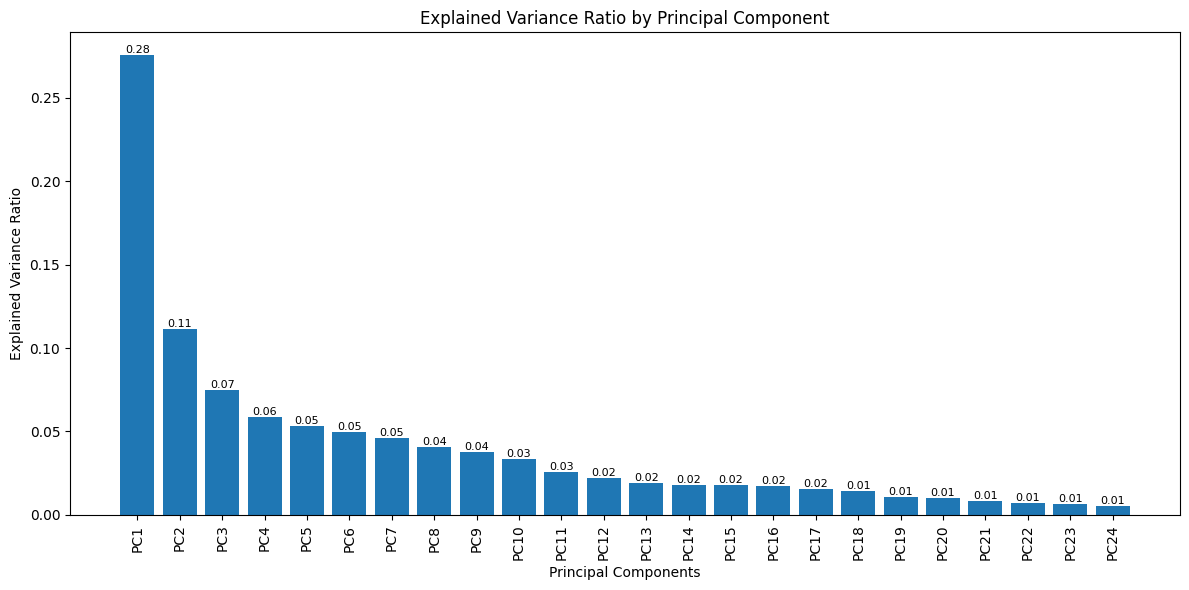

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA # Import PCA

# --- Visualise variance distribution ---

# Get explained variance ratio from the PCA object
explained_variance_ratio = pca.explained_variance_ratio_

# Create labels for the x-axis (PC1, PC2, ...)
pc_labels = [f'PC{i+1}' for i in range(len(explained_variance_ratio))]

# Create the plot
plt.figure(figsize=(12, 6))
bars = plt.bar(pc_labels, explained_variance_ratio)

# Add values above each bar
for bar, val in zip(bars, explained_variance_ratio):
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # x position (center of bar)
        bar.get_height(),                   # y position (top of bar)
        f"{val:.2f}",                       # format value (2 decimal places)
        ha='center', va='bottom', fontsize=8
    )

plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Component')
plt.xticks(rotation=90) # Rotate labels for better readability
plt.tight_layout()
plt.show()


#Scatter plots of PCA
https://plotly.com/python/pca-visualization/

# Data reshaping for 1D CNN input

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.decomposition import PCA

# Reshape the data so it can be used as input for the 1D CNN (1D CNN expects input shape: (samples, timesteps, channels) - timesteps = number of features)
X_train = pcaX_train.reshape((pcaX_train.shape[0], pcaX_train.shape[1], 1))
X_val = pcaX_val.reshape((pcaX_val.shape[0], pcaX_val.shape[1], 1))
X_test = pcaX_test.reshape((pcaX_test.shape[0], pcaX_test.shape[1], 1))

# Sanity check
print("Training input shape:", X_train.shape)
print("Validation input shape:", X_val.shape)
print("Test input shape:", X_test.shape)

Training input shape: (1613280, 24, 1)
Validation input shape: (403320, 24, 1)
Test input shape: (504151, 24, 1)


#1D CNN model

Best model for the Datasets/cicids2017_cleaned.csv

In [8]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input

# # Define input shape
# input_shape = (X_train.shape[1], 1)  # (timesteps, features)
# num_classes = len(attack_type_map) # Get the number of unique attack types for the output layer

# # Build model
# model = Sequential([
#     Input(shape=input_shape),

#     Conv1D(filters=64, kernel_size=3, activation='relu'), # Detect patterns in the network traffic data
#     BatchNormalization(), # Normalizes the outputs of a the Conv1D layer before passing them to the MaxPool layer
#     MaxPooling1D(pool_size=2), # Reduce the dimensions of the data without affecting key features

#     Conv1D(filters=32, kernel_size=3, activation='relu'),
#     BatchNormalization(),
#     MaxPooling1D(pool_size=2),

#     Flatten(), # Converts the output of the last Conv1D layer into a 1D vector for the fully connected layers
#     Dense(16, activation='relu'), # Apply L2 regularisation to prevent overfitting (common in the dense layer) #https://medium.com/@bhatadithya54764118/day-49-overfitting-and-underfitting-in-dl-regularization-techniques-8ded20baa3d6
#     Dense(num_classes, activation='softmax')  # Final output layer for multiclass classification
# ])

# # Compile
# model.compile( optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) # Loss function measures how well the model’s predictions match true labels #'adam'

# print(model.summary())



Baseline CNN code

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input

# Define input shape
input_shape = (X_train.shape[1], 1)  # (timesteps, features)
num_classes = len(attack_type_map) # Get the number of unique attack types for the output layer

# Build model
model = Sequential([
    Input(shape=input_shape),

    Conv1D(filters=64, kernel_size=2, activation='relu'), # Detect patterns in the network traffic data
    BatchNormalization(), # Normalizes the outputs of a the Conv1D layer before passing them to the MaxPool layer
    MaxPooling1D(pool_size=2), # Reduce the dimensions of the data without affecting key features
    Dropout(0.3),

    Conv1D(filters=128, kernel_size=2, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(), # Converts the output of the last Conv1D layer into a 1D vector for the fully connected layers
    Dense(32, activation='relu'), # Apply L2 regularisation to prevent overfitting (common in the dense layer) #https://medium.com/@bhatadithya54764118/day-49-overfitting-and-underfitting-in-dl-regularization-techniques-8ded20baa3d6
    Dropout(0.2), # Randomly drop 50% of the network's neurons to further prevent overfitting
    Dense(num_classes, activation='softmax')  # Final output layer for multiclass classification
])

# Compile
model.compile( optimizer = 'adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']) # Loss function measures how well the model’s predictions match true labels #'adam'

# Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 23, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 23, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 128)        │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        20,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,215 (149.28 KB)

 Trainable params: 37,831 (147.78 KB)

 Non-trainable params: 384 (1.50 KB)

#Training the 1D CNN model

Epoch 1/20
25208/25208 ━━━━━━━━━━━━━━━━━━━━ 105s 4ms/step - accuracy: 0.9609 - loss: 0.1083 - val_accuracy: 0.9758 - val_loss: 0.0530
Epoch 2/20
25208/25208 ━━━━━━━━━━━━━━━━━━━━ 133s 4ms/step - accuracy: 0.9744 - loss: 0.0619 - val_accuracy: 0.9813 - val_loss: 0.0475
Epoch 3/20
25208/25208 ━━━━━━━━━━━━━━━━━━━━ 93s 4ms/step - accuracy: 0.9760 - loss: 0.0569 - val_accuracy: 0.9784 - val_loss: 0.0457
Epoch 4/20
25208/25208 ━━━━━━━━━━━━━━━━━━━━ 135s 3ms/step - accuracy: 0.9771 - loss: 0.0542 - val_accuracy: 0.9782 - val_loss: 0.0472
Epoch 5/20
25208/25208 ━━━━━━━━━━━━━━━━━━━━ 149s 4ms/step - accuracy: 0.9775 - loss: 0.0533 - val_accuracy: 0.9806 - val_loss: 0.0425
Epoch 6/20
25208/25208 ━━━━━━━━━━━━━━━━━━━━ 135s 3ms/step - accuracy: 0.9781 - loss: 0.0519 - val_accuracy: 0.9771 - val_loss: 0.0491
Epoch 7/20
25208/25208 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step - accuracy: 0.9780 - loss: 0.0517 - val_accuracy: 0.9825 - val_loss: 0.0406
Epoch 8/20
25208/25208 ━━━━━━━━━━━━━━━━━━━━ 94s 4ms/step - accur

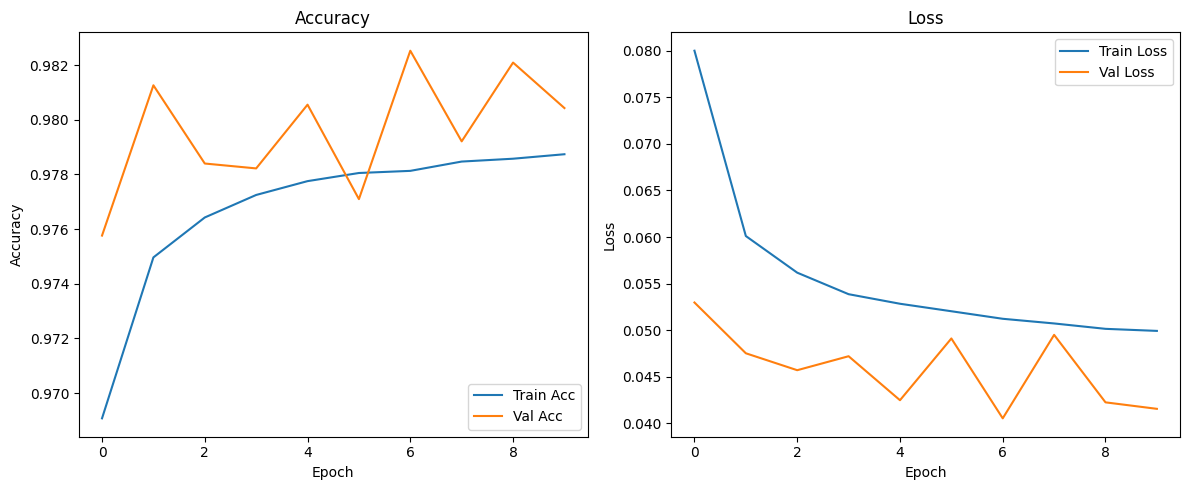

In [10]:
import matplotlib.pyplot as plt
import timeit
from tensorflow.keras.callbacks import EarlyStopping

# --- Early-stopping --- #TESTING
# https://medium.com/@piyushkashyap045/early-stopping-in-deep-learning-a-simple-guide-to-prevent-overfitting-1073f56b493e
# Early-stopping is a regularisation technique that prevents overfitting by stopping the training process when the model’s performance on the validation dataset starts degrading
# Stopping early reduces training time and computational costs

early_stopping = EarlyStopping(monitor='val_loss', # Specify monitor='val_loss' to track the validation loss.
                               patience=3, #the number of epochs to wait for an improvement
                               restore_best_weights=True) # Revert the model to its state where it outputted the lowest validation loss

# Train the model with early stopping
start_time = timeit.default_timer()
history = model.fit(
    X_train, y_train,
    epochs= 20, #10
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)


end_time = timeit.default_timer()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Plot accuracy and loss
plt.figure(figsize=(12,5)) # Create a new figure that is 12x5

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



# Evaluate 1D CNN Malware Detection Results

15755/15755 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step

Confusion Matrix:


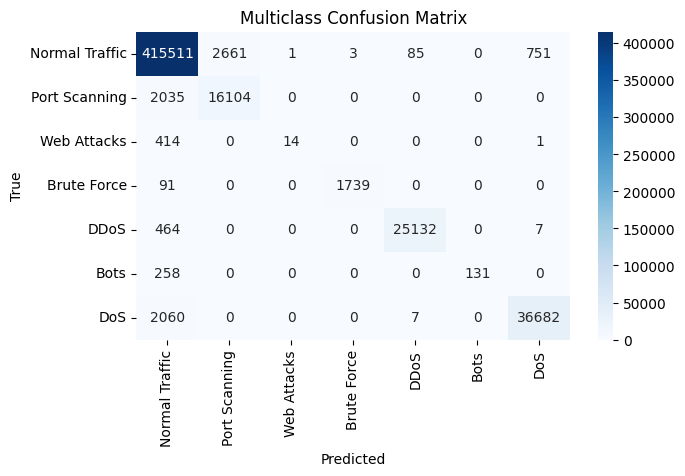


Accuracy:
sklearn Accuracy: 0.9824695378963842
model.evaluate Accuracy: 0.9825

Classification Report:
                precision    recall  f1-score   support

Normal Traffic       0.99      0.99      0.99    419012
 Port Scanning       0.86      0.89      0.87     18139
   Web Attacks       0.93      0.03      0.06       429
   Brute Force       1.00      0.95      0.97      1830
          DDoS       1.00      0.98      0.99     25603
          Bots       1.00      0.34      0.50       389
           DoS       0.98      0.95      0.96     38749

      accuracy                           0.98    504151
     macro avg       0.96      0.73      0.76    504151
  weighted avg       0.98      0.98      0.98    504151

Total Malware Samples: 85139
Total Benign Samples: 419012

TP, TN, FP, FN for Malware vs Benign:
True Positives (Malware predicted as Malware): 79802 (93.73% of Malware Identified)
True Negatives (Benign predicted as Benign): 415511
False Positives (Benign predicted as Malware

In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns # Import seaborn for heatmap plotting
import numpy as np # Import numpy
import matplotlib.pyplot as plt # Import matplotlib for plotting

# Get models predictions of x_test dataset
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)# For multiclass classification, the prediction is the class with the highest probability

# --- Confusion matrix ---
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")

# --- CM Heatmap ---
# Get the original attack type names from the mapping
reverse_attack_type_map = {v: k for k, v in attack_type_map.items()}
labels = [reverse_attack_type_map.get(i, f'Unknown {i}') for i in range(cm.shape[0])] # Use matrix shape for label count

# Plot heatmap
plt.figure(figsize=(7, 4)) # Adjust figure size
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Multiclass Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Accuracy scores
print("\nAccuracy:")
print("sklearn Accuracy:", accuracy_score(y_test, y_pred))
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)# Evaluate model with test set
print(f"model.evaluate Accuracy: {test_acc:.4f}")

# Classification report (accuracy, precision, recall, F1)
print("\nClassification Report:")
# target_names should be the actual class names
report = classification_report(y_test, y_pred, target_names=labels, output_dict=True)
print(classification_report(y_test, y_pred, target_names=labels))

# --- Custom Metrics for Malware vs Benign (Normal Traffic) ---
normal_traffic_label = attack_type_map.get('Normal Traffic', None)

if normal_traffic_label is not None: #if there are benign samples

    malware_identified_count = np.sum(np.diag(cm)) - cm[normal_traffic_label, normal_traffic_label]# True Positives for Malware = sum of diagonals excluding 'Normal Traffic'

    total_malware_count = np.sum(cm) - np.sum(cm[normal_traffic_label, :])# Total Malware = sum of all non-'Normal Traffic' samples

    percentage_malware_identified_overall = (malware_identified_count / total_malware_count) * 100 if total_malware_count > 0 else 0  # % of Malware Identified (overall)

    # False Positives = Non-'Normal' samples predicted as 'Normal'
    benign_not_identified_count = np.sum(cm[normal_traffic_label, :]) - cm[normal_traffic_label, normal_traffic_label]
    total_benign_count = np.sum(cm[normal_traffic_label, :])

    percentage_benign_not_identified = (benign_not_identified_count / total_benign_count) * 100 if total_benign_count > 0 else 0 # % of Benign Traffic Misclassified

    print(f"Total Malware Samples: {total_malware_count}")
    print(f"Total Benign Samples: {total_benign_count}")

    # --- Calculate and print TP, TN, FP, FN for Malware vs Benign ---
    # For binary classification (Malware vs Benign):
    # TP: Malware correctly predicted as Malware (malware_identified_count)
    # TN: Benign correctly predicted as Benign (cm[normal_traffic_label, normal_traffic_label])
    # FP: Benign incorrectly predicted as Malware (benign_not_identified_count)
    # FN: Malware incorrectly predicted as Benign (Total Malware Samples - Malware Identified)

    tp = malware_identified_count
    tn = cm[normal_traffic_label, normal_traffic_label]
    fp = benign_not_identified_count
    fn = total_malware_count - malware_identified_count

    print("\nTP, TN, FP, FN for Malware vs Benign:")
    print(f"True Positives (Malware predicted as Malware): {tp} ({percentage_malware_identified_overall:.2f}% of Malware Identified)")
    print(f"True Negatives (Benign predicted as Benign): {tn}")
    print(f"False Positives (Benign predicted as Malware): {fp} ({percentage_benign_not_identified:.2f}% of Benign Misclassified)")
    print(f"False Negatives (Malware predicted as Benign): {fn}")

    # --- Percentage of each malware class correctly identified ---
    print("\nPercentage of each Malware Class Correctly Identified:")
    for i, label in enumerate(labels):
        if i != normal_traffic_label: # Exclude 'Normal Traffic'
            correctly_identified = cm[i, i]
            total_in_class = np.sum(cm[i, :])
            percentage_identified = (correctly_identified / total_in_class) * 100 if total_in_class > 0 else 0
            print(f"{label}: {percentage_identified:.2f}%")

# Save the datasets for the quantised models

In [12]:
# import pandas as pd
# import os

# save_path = "/content/drive/MyDrive/Colab Notebooks/Honours Project/Sian\'s Models/PCA-CNN files"
# os.makedirs(save_path, exist_ok=True)

# # Reverse the attack_type_map: numeric -> name
# inv_attack_type_map = {v: k for k, v in attack_type_map.items()}
# reverse_attack_type_map = {v: k for k, v in attack_type_map.items()}

# # Convert numeric labels to proper names
# y_train = [reverse_attack_type_map[i] for i in y_train.ravel()]
# y_val = [reverse_attack_type_map[i] for i in y_val.ravel()]
# y_test = [reverse_attack_type_map[i] for i in y_test.ravel()]

# # Reshape the X data back to 2D before creating DataFrames
# X_train = X_train.reshape((X_train.shape[0], X_train.shape[1]))
# X_val = X_val.reshape((X_val.shape[0], X_val.shape[1]))
# X_test = X_test.reshape((X_test.shape[0], X_test.shape[1]))

# # Combine X and y into DataFrames
# train_combined = pd.concat(
#     [pd.DataFrame(X_train, columns=[f'PC{i+1}' for i in range(X_train_2d.shape[1])]),
#      pd.DataFrame(y_train, columns=["Attack Type"])],
#     axis=1
# )

# val_combined = pd.concat(
#     [pd.DataFrame(X_val, columns=[f'PC{i+1}' for i in range(X_val_2d.shape[1])]),
#      pd.DataFrame(y_val, columns=["Attack Type"])],
#     axis=1
# )

# test_combined = pd.concat(
#     [pd.DataFrame(X_test, columns=[f'PC{i+1}' for i in range(X_test_2d.shape[1])]),
#      pd.DataFrame(y_test, columns=["Attack Type"])],
#     axis=1
# )

# # Save the combined datasets
# train_combined.to_csv(os.path.join(save_path, "pca_cnn_train.csv"), index=False)
# val_combined.to_csv(os.path.join(save_path, "pca_cnn_val.csv"), index=False)
# test_combined.to_csv(os.path.join(save_path, "pca_cnn_test.csv"), index=False)

# print("Datasets saved successfully with proper Attack Type names!")

# Save best models

In [13]:
# import pickle
# import os

# # Define the directory path
# save_dir = '/content/drive/MyDrive/Colab Notebooks/Honours Project/Sian\'s Models'

# # Create the directory if it doesn't exist
# os.makedirs(save_dir, exist_ok=True)

# # Save the trained model
# model_path = os.path.join(save_dir, '1D_CNN_IDS_94_90_ADASYN.keras')
# model.save(model_path)  # Native Keras format
# print(f"Model saved as {model_path}")

# # Save the trained PCA object
# pca_path = os.path.join(save_dir, 'PCA_94_90_ADASYN.pkl')
# with open(pca_path, 'wb') as f:
#     pickle.dump(pca, f)
# print(f"PCA object saved as {pca_path}")

#Quantisation